#                                       _SciBot_
##                             Satyaki Sikdar, Famim Talukder

Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import string
from collections import Counter
import pickle
from fim import apriori, fpgrowth
# add sklearn

%matplotlib inline

---

## TASK 1

 Loading data

### index.txt
1. Folder name in pdf.zip/txt.zip
2. PDFID (file name) in pdf.zip (*.pdf) /txt.zip (*.txt):(paper id in PDFs)
3. PID (paper id in
4. MAS database)
5. TITLE (lower case)

In [2]:
index = pd.read_csv('./microsoft/index.txt', sep='\t', header=None, names=['folder', 'PDFid', 'PID', 'title'])

In [286]:
index.tail()

folder      PDFid       PID  \
5848  www15  www15-d94  80D3A78B   
5849  www15  www15-d95  834D279C   
5850  www15  www15-d96  73C1D7DB   
5851  www15  www15-d97  405193FE   
5852  www15  www15-d98  81495B50   

                                                  title  
5848  online searching in english as a foreign language  
5849  understanding malvertising through ad injectin...  
5850                   temex the web template extractor  
5851  social personal data stores the nuclei of dece...  
5852    network a b testing from sampling to estimation

---

### papers.txt

1. PID (paper id in MAS database)
2. TITLE_CASE (case sensitive)
3. TITLE (lower case)
4. YEAR (year of proceeding)
5. DATE_OF_PROCEEDING (not recommended to use)
6. DOI (not recommended to use)
7. CONF_FULL_NAME (not recommended to use)
8. CONF (abbreviation, lower case)*
9. N/A
10. CID (conference id; not proceeding id!)**
11. N/A

\* The dataset is noisy. NOT every entry can be correlated across the files, for example,
CONF has conference names that are not included in {icdm, kdd, wsdm, www}.

\** One-to-one mapping between CONF and CID.

In [4]:
papers = pd.read_csv('./microsoft/Papers.txt', sep='\t', header=None, 
                        names=['PID', 'title_case', 'title', 'year', 'date', 'doi', 
                               'conf_full_name', 'conf', 'NA1', 'CID', 'NA2'])

In [5]:
papers.drop(['date', 'doi', 'conf_full_name', 'NA1', 'NA2', 'title'], inplace=True, axis=1)

In [6]:
papers.head()

PID                                         title_case  year   conf  \
0  01B27BE8  Evaluating Polarity for Verbal Phraseological ...  2014  micai   
1  027D0030  Automatic Monitoring the Content of Audio Broa...  2012  micai   
2  7CFE299E  Towards a set of Measures for Evaluating Softw...  2009  micai   
3  59BEBE1C  Learning Probability Densities of Optimization...  2008  micai   
4  5873C011               Towards a Model for an Immune System  2002  micai   

        CID  
0  42D7146F  
1  42D7146F  
2  42D7146F  
3  42D7146F  
4  42D7146F

In [7]:
papers.shape

(201256, 5)

Taking into account only the papers which have **PID** in the index table

In [50]:
papers = pd.merge(papers, index, on='PID')

In [51]:
papers = papers[papers.PID.isin(index.PID)]

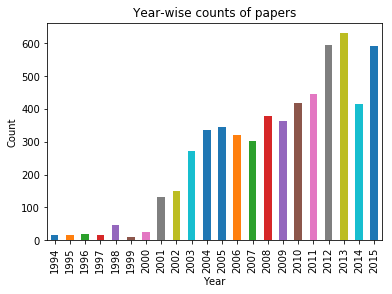

In [52]:
order = sorted(papers.year)
papers.year.value_counts().sort_index().plot(kind='bar');
plt.title('Year-wise counts of papers');
plt.xlabel('Year');
plt.ylabel('Count');
plt.savefig('./plots/year_count.png', dpi=600, bbox_inches='tight')

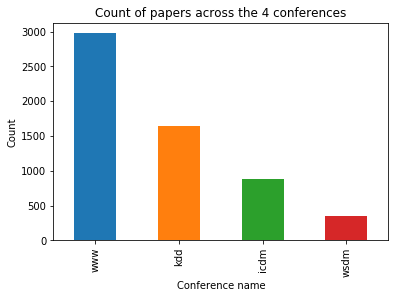

In [158]:
papers.conf.value_counts().plot(kind='bar');
plt.title('Count of papers across the 4 conferences');
plt.xlabel('Conference name');
plt.ylabel('Count');
plt.savefig('./plots/conf_count.png', dpi=600, bbox_inches='tight')

---

## PaperKeyword

1. PID (paper id in MAS)
2. KEYWORD (lowercase)
3. KID (keyword ID)

In [53]:
paper_key = pd.read_csv('./microsoft/PaperKeywords.txt', sep='\t', names=['PID', 'keyword', 'KID'], dtype=str)

In [54]:
paper_key.head()

PID                keyword       KID
0  00024268             depression  0A69E142
1  000A2058               ontology  0189D6E8
2  000BC41A       machine learning  0724DFBA
3  00180FA0  posterior probability  03726BFA
4  00185166           semantic web  00207EA7

Considering only those PIDs that are in *papers.txt*

In [55]:
paper_key = paper_key[paper_key.PID.isin(papers.PID)]

In [56]:
keyword_series = paper_key.groupby('PID', sort=False)['keyword'].apply(list)

Aggregating the keywords of the same paper into a list

In [57]:
keywords = pd.DataFrame({'PID': keyword_series.index, 'Keywords': keyword_series.values})

In [58]:
keywords.head()

Keywords       PID
0                                 [association rule]  0133FF05
1      [language models, topic models, social media]  01BFDC05
2  [hierarchical, spatial, temporal, relation ext...  02BAD2BD
3          [search engine, web pages, link analysis]  0498B190
4  [semantic web, object oriented, user experienc...  0499D194

Merge the papers and keywords tables together

In [59]:
papers_keywords = pd.merge(papers, keywords, on='PID')

In [60]:
papers_keywords.head()

PID                                         title_case  year conf  \
0  7A81E8D5  Stochastic Divergence Minimization for Online ...  2015  kdd   
1  7D60588D  Grafting-light: fast, incremental feature sele...  2010  kdd   
2  76065173                            Debiasing social wisdom  2013  kdd   
3  7D72D04B                 The contextual focused topic model  2012  kdd   
4  768B16AB  Interpreting Advertiser Intent in Sponsored Se...  2015  kdd   

        CID folder        PDFid  \
0  436976F3  kdd15  kdd15-p1035   
1  436976F3  kdd10    kdd10-d81   
2  436976F3  kdd13    kdd13-d48   
3  436976F3  kdd12   kdd12-d202   
4  436976F3  kdd15  kdd15-p2177   

                                               title  \
0  stochastic divergence minimization for online ...   
1  grafting light fast incremental feature select...   
2                            debiasing social wisdom   
3                 the contextual focused topic model   
4  interpreting advertiser intent in sponsored se...   

                                            Keywords  
0  [topic modeling, latent dirichlet allocation, ...  
1  [algorithms, feature selection, maximum likeli...  
2                                  [social networks]  
3       [topic modeling, clustering, random effects]  
4                               [online advertising]

---

## PaperAuthorAffiliation
1. PID (paper id in MAS database)
2. AID (author id in MAS database)
3. FID (affiliation id in MAS database)
4. AFF_ORG (original affiliation name, not recommended to use)
5. AFF (normalized affiliation name)\*
6. SID (author sequence number: “1” = the first author, “3” = the 3rd author) \**

\* One-to-one mapping between AFF and FID.

\** The author information of a paper may not be complete. It may only have the 1st, 2nd, and 4th authors.

In [61]:
paper_auth_aff = pd.read_csv('./microsoft/PaperAuthorAffiliations.txt', sep='\t', names=['PID', 'AID', 'FID',
                                                                                     'AFF_ORG', 'AFF', 'SID'],
                         dtype={'PID': str, 'AID': str, 'FID': str, 'AFF_ORG': str, 'AFF': str, 'SID': int})

Consider only the ones that are in index

In [62]:
papers_auth_aff = paper_auth_aff[paper_auth_aff.PID.isin(papers.PID)]

Dropping AFF_ORG column and the ones which do not have a AFF and FID

In [63]:
paper_auth_aff.drop(['AFF_ORG'], axis=1, inplace=True)

In [64]:
paper_auth_aff.dropna(subset=['AFF', 'FID'], inplace=True)

In [65]:
paper_auth_aff.head()

PID       AID       FID                  AFF  SID
0  7ECEB907  857A3FC3  07F5B6CA  harvey mudd college    2
1  83692C15  7978233F  07F5B6CA  harvey mudd college    1
2  5AEEB55E  7A7BBFEF  07F5B6CA  harvey mudd college    3
3  5AE8573A  7DA932AC  07F5B6CA  harvey mudd college    3
4  7555125A  71924C59  07F5B6CA  harvey mudd college    5

#### Bar plot of distribution of SIDs

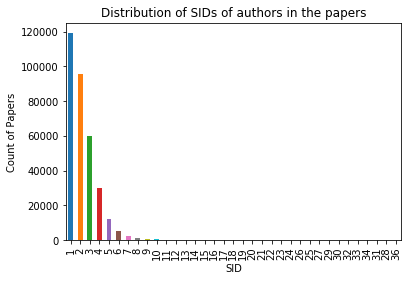

In [66]:
paper_auth_aff.SID.value_counts().plot(kind='bar')
plt.title('Distribution of SIDs of authors in the papers');
plt.xlabel('SID');
plt.ylabel('Count of Papers');
plt.savefig('./plots/raw_SID.png', dpi=600, bbox_inches='tight')

Further cleaning by getting rid of the rows that have SID > 10

In [67]:
paper_auth_aff = paper_auth_aff[paper_auth_aff.SID <= 10]

Cleaned bar plot

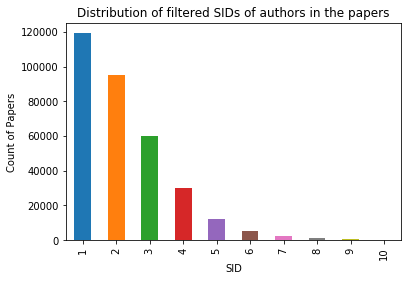

In [71]:
plt.title('Distribution of filtered SIDs of authors in the papers');
plt.xlabel('SID');
plt.ylabel('Count of Papers');
paper_auth_aff[paper_auth_aff.SID <= 10].SID.value_counts().plot(kind='bar')
plt.savefig('./plots/fil_SID.png', dpi=600, bbox_inches='tight')

In [72]:
paper_auth_aff.head()

PID       AID       FID                  AFF  SID
0  7ECEB907  857A3FC3  07F5B6CA  harvey mudd college    2
1  83692C15  7978233F  07F5B6CA  harvey mudd college    1
2  5AEEB55E  7A7BBFEF  07F5B6CA  harvey mudd college    3
3  5AE8573A  7DA932AC  07F5B6CA  harvey mudd college    3
4  7555125A  71924C59  07F5B6CA  harvey mudd college    5

---

## Authors.txt
1. AID 
2. AUT (author name in lower case)

In [73]:
author = pd.read_csv('./microsoft/Authors.txt', sep='\t', names=['AID', 'AUT'], dtype=str)

Considering only authors in *paper_auth_aff*

In [74]:
author = author[author.AID.isin(papers_auth_aff.AID)]

In [75]:
author.AID.unique().shape

(12108,)

#### merging authors and author aff


In [76]:
authors_with_aff = pd.merge(paper_auth_aff, author, on='AID')

In [77]:
authors_with_aff.head()

PID       AID       FID                  AFF  SID             AUT
0  7555125A  81243752  07F5B6CA  harvey mudd college    6   ayman farahat
1  8146A8F4  81243752  0A575E93                 parc    2   ayman farahat
2  7923D0E6  81243752  0A575E93                 parc    1   ayman farahat
3  5C3C6F9D  80143FAE  07F5B6CA  harvey mudd college    1  david f gleich
4  76ADC390  80143FAE  0D109F83    purdue university    3  david f gleich

Filtering only the papers in the papers df

In [78]:
authors_with_aff = authors_with_aff[authors_with_aff.PID.isin(papers.PID)]

In [79]:
authors_with_aff.sort_values(by='SID', inplace=True)

In [80]:
authors_with_aff[(authors_with_aff.AUT.str.startswith('meng jiang')) | 
                (authors_with_aff.AUT.str.endswith('weninger'))]

PID       AID       FID  \
65467  7D418997  7E150205  05E79D01   
65461  786333F5  7E150205  05E79D01   
65465  7E448DF1  7E150205  05E79D01   
54449  78604E25  79741159  0966B229   
54446  7A21FF78  79741159  0966B229   
54445  7FE9638C  79741159  0966B229   
54447  77FF1E20  79741159  0966B229   
54450  78A5C59B  79741159  0966B229   

                                              AFF  SID           AUT  
65467                         tsinghua university    1    meng jiang  
65461                         tsinghua university    1    meng jiang  
65465                         tsinghua university    1    meng jiang  
54449  university of illinois at urbana champaign    1  tim weninger  
54446  university of illinois at urbana champaign    1  tim weninger  
54445  university of illinois at urbana champaign    2  tim weninger  
54447  university of illinois at urbana champaign    3  tim weninger  
54450  university of illinois at urbana champaign    3  tim weninger

Grouping the authors of the same paper

Aggregating the AIDs, AUTs, FIDs and AFFs

In [81]:
auth_id_series = authors_with_aff.groupby('PID',)['AID'].apply(list)

In [82]:
auth_name_series = authors_with_aff.groupby('PID',)['AUT'].apply(list)

In [83]:
aff_id_series = authors_with_aff.groupby('PID',)['FID'].apply(list)

In [84]:
aff_name_series = authors_with_aff.groupby('PID',)['AFF'].apply(list)

In [85]:
authors = pd.DataFrame({'PID': auth_id_series.index, 'AIDs': auth_id_series.values,
                       'AUTs': auth_name_series.values, 'AFFs': aff_name_series,
                      'FIDs': aff_id_series})

In [86]:
authors.head()

AFFs  \
PID                                                           
000BD259                                [peking university]   
0019D7E3                    [university of texas at austin]   
001CA44D  [pennsylvania state university, pennsylvania s...   
003AAC4E  [vienna university of technology, vienna unive...   
00533F1E  [tsinghua university, tsinghua university, hon...   

                                              AIDs  \
PID                                                  
000BD259                                [85292E99]   
0019D7E3                                [7E511C22]   
001CA44D            [02A0FF54, 7D05128D, 7F5C04E2]   
003AAC4E  [02887148, 7B3361CE, 7EEF3DEE, 7B1F1FC7]   
00533F1E  [803EF185, 7EC8A561, 7F53CAD0, 7F575097]   

                                                       AUTs  \
PID                                                           
000BD259                                          [ning xu]   
0019D7E3                                   [hyun joon jung]   
001CA44D      [anna squicciarini, jules dupont, ruyan chen]   
003AAC4E  [nataliia pobiedina, julia neidhardt, maria de...   
00533F1E  [xiaochen zhang, xiaoming jin, lianghao li, do...   

                                              FIDs       PID  
PID                                                           
000BD259                                [0134B592]  000BD259  
0019D7E3                                [05282E0D]  0019D7E3  
001CA44D            [07CB626B, 07CB626B, 07CB626B]  001CA44D  
003AAC4E  [08B17323, 08B17323, 08B17323, 08B17323]  003AAC4E  
00533F1E  [05E79D01, 05E79D01, 0BF77E37, 05E79D01]  00533F1E

In [87]:
authors[authors.PID == '776E2648']

AFFs  \
PID                                                           
776E2648  [university of notre dame, university of notre...   

                                    AIDs  \
PID                                        
776E2648  [109A673C, 7DA9ABBD, 76014D6E]   

                                                       AUTs  \
PID                                                           
776E2648  [ryan n lichtenwalter, jake t lussier, nitesh ...   

                                    FIDs       PID  
PID                                                 
776E2648  [066A71BC, 066A71BC, 066A71BC]  776E2648

---

Merging papers_keywords and authors

In [88]:
papers_keywords.head()

PID                                         title_case  year conf  \
0  7A81E8D5  Stochastic Divergence Minimization for Online ...  2015  kdd   
1  7D60588D  Grafting-light: fast, incremental feature sele...  2010  kdd   
2  76065173                            Debiasing social wisdom  2013  kdd   
3  7D72D04B                 The contextual focused topic model  2012  kdd   
4  768B16AB  Interpreting Advertiser Intent in Sponsored Se...  2015  kdd   

        CID folder        PDFid  \
0  436976F3  kdd15  kdd15-p1035   
1  436976F3  kdd10    kdd10-d81   
2  436976F3  kdd13    kdd13-d48   
3  436976F3  kdd12   kdd12-d202   
4  436976F3  kdd15  kdd15-p2177   

                                               title  \
0  stochastic divergence minimization for online ...   
1  grafting light fast incremental feature select...   
2                            debiasing social wisdom   
3                 the contextual focused topic model   
4  interpreting advertiser intent in sponsored se...   

                                            Keywords  
0  [topic modeling, latent dirichlet allocation, ...  
1  [algorithms, feature selection, maximum likeli...  
2                                  [social networks]  
3       [topic modeling, clustering, random effects]  
4                               [online advertising]

In [89]:
authors.head()

AFFs  \
PID                                                           
000BD259                                [peking university]   
0019D7E3                    [university of texas at austin]   
001CA44D  [pennsylvania state university, pennsylvania s...   
003AAC4E  [vienna university of technology, vienna unive...   
00533F1E  [tsinghua university, tsinghua university, hon...   

                                              AIDs  \
PID                                                  
000BD259                                [85292E99]   
0019D7E3                                [7E511C22]   
001CA44D            [02A0FF54, 7D05128D, 7F5C04E2]   
003AAC4E  [02887148, 7B3361CE, 7EEF3DEE, 7B1F1FC7]   
00533F1E  [803EF185, 7EC8A561, 7F53CAD0, 7F575097]   

                                                       AUTs  \
PID                                                           
000BD259                                          [ning xu]   
0019D7E3                                   [hyun joon jung]   
001CA44D      [anna squicciarini, jules dupont, ruyan chen]   
003AAC4E  [nataliia pobiedina, julia neidhardt, maria de...   
00533F1E  [xiaochen zhang, xiaoming jin, lianghao li, do...   

                                              FIDs       PID  
PID                                                           
000BD259                                [0134B592]  000BD259  
0019D7E3                                [05282E0D]  0019D7E3  
001CA44D            [07CB626B, 07CB626B, 07CB626B]  001CA44D  
003AAC4E  [08B17323, 08B17323, 08B17323, 08B17323]  003AAC4E  
00533F1E  [05E79D01, 05E79D01, 0BF77E37, 05E79D01]  00533F1E

Considering only the ones which occur in both the tables

In [90]:
papers_auths = pd.merge(papers_keywords, authors, on='PID')

In [91]:
papers_auths.head()

PID                                         title_case  year conf  \
0  7A81E8D5  Stochastic Divergence Minimization for Online ...  2015  kdd   
1  7D60588D  Grafting-light: fast, incremental feature sele...  2010  kdd   
2  76065173                            Debiasing social wisdom  2013  kdd   
3  7D72D04B                 The contextual focused topic model  2012  kdd   
4  768B16AB  Interpreting Advertiser Intent in Sponsored Se...  2015  kdd   

        CID folder        PDFid  \
0  436976F3  kdd15  kdd15-p1035   
1  436976F3  kdd10    kdd10-d81   
2  436976F3  kdd13    kdd13-d48   
3  436976F3  kdd12   kdd12-d202   
4  436976F3  kdd15  kdd15-p2177   

                                               title  \
0  stochastic divergence minimization for online ...   
1  grafting light fast incremental feature select...   
2                            debiasing social wisdom   
3                 the contextual focused topic model   
4  interpreting advertiser intent in sponsored se...   

                                            Keywords  \
0  [topic modeling, latent dirichlet allocation, ...   
1  [algorithms, feature selection, maximum likeli...   
2                                  [social networks]   
3       [topic modeling, clustering, random effects]   
4                               [online advertising]   

                                                AFFs  \
0         [university of tokyo, university of tokyo]   
1  [carnegie mellon university, carnegie mellon u...   
2       [microsoft, microsoft, microsoft, microsoft]   
3  [duke university, duke university, duke univer...   
4  [university of california san diego, microsoft...   

                                                AIDs  \
0                               [800DD778, 817628DB]   
1                     [84A938BA, 7FDD7A85, 14EED946]   
2           [7E17537C, 78986B23, 7B6F49C4, 84FF4740]   
3                     [84B613E3, 81583A41, 272FB205]   
4  [7A3643B2, 84E4D65D, 85305AA4, 80B1DC4A, 7FF0D...   

                                                AUTs  \
0                     [issei sato, hiroshi nakagawa]   
1                     [jun zhu, ni lao, eric p xing]   
2  [abhimanyu das, sreenivas gollapudi, rina pani...   
3           [xu chen, mingyuan zhou, lawrence carin]   
4  [bhanu c vattikonda, santhosh kodipaka, hongya...   

                                                FIDs  
0                               [04756336, 04756336]  
1                     [0477FFD3, 0477FFD3, 0477FFD3]  
2           [4CE6FC2D, 4CE6FC2D, 4CE6FC2D, 4CE6FC2D]  
3                     [0A2FAFA5, 0A2FAFA5, 0A2FAFA5]  
4  [0229448F, 4CE6FC2D, 4CE6FC2D, 4CE6FC2D, 4CE6F...

In [300]:
papers_auths[papers_auths.PID == '776E2648'].title_case.values[0]

'New perspectives and methods in link prediction'

## Task 1 - done!!

---

## Task 2

Add the texts into the dataframe

In [93]:
texts = {}
for row in papers_auths.itertuples():
    filename = './text/' + row.PDFid[: row.PDFid.find('-')] + '/' + row.PDFid + '.txt'
    with open(filename) as f:
        txt = f.read()
    texts[row.PID] = txt  

In [94]:
papers_auths['Text'] = texts.values()

st1, st2 and st3 form a set of punctuations and symbols that we could find in the papers

In [96]:
st1 = set(string.punctuation)
st2 = set([',','.','--','!','?',';','(',')','/','"'])
st3 = set(['--', 'ß', '≤','≥','\'','’','ˆ','µ','±','ï',
           'ð','î','©','è','<','>','α','_', 'φ', 'θ'])
punct = st1 | st2 | st3

We read the stopwords from 'stopwords.txt'

In [97]:
with open('stopwords.txt', 'r') as f:
    stopwords = set()
    for line in f:
        stopwords.add(line.strip())    

The easy tokenizer is adapted from Dr. Jiang's ResponseBot demo

In [98]:
from string import punctuation
def easy_tokenizer(text):
    ret = []
    for x in punct:
        text = text.replace(x, ' ')
    for x in ['\n', '\r', '\t', '\x00']:
        text = text.replace(x, ' ')
    for word in text.split(' '):
        word = word.strip().lower()
        if word == '' or word == ' ': continue
        if not word.isalpha() or len(word) == 1 or word in stopwords:
            continue
        ret.append(word)
    return ret

In [99]:
papers_auths['fil_text'] = papers_auths.Text.apply(lambda x: ' '.join(easy_tokenizer(x)))

In [100]:
papers_auths.head(2)

PID                                         title_case  year conf  \
0  7A81E8D5  Stochastic Divergence Minimization for Online ...  2015  kdd   
1  7D60588D  Grafting-light: fast, incremental feature sele...  2010  kdd   

        CID folder        PDFid  \
0  436976F3  kdd15  kdd15-p1035   
1  436976F3  kdd10    kdd10-d81   

                                               title  \
0  stochastic divergence minimization for online ...   
1  grafting light fast incremental feature select...   

                                            Keywords  \
0  [topic modeling, latent dirichlet allocation, ...   
1  [algorithms, feature selection, maximum likeli...   

                                                AFFs  \
0         [university of tokyo, university of tokyo]   
1  [carnegie mellon university, carnegie mellon u...   

                             AIDs                            AUTs  \
0            [800DD778, 817628DB]  [issei sato, hiroshi nakagawa]   
1  [84A938BA, 7FDD7A85, 14EED946]  [jun zhu, ni lao, eric p xing]   

                             FIDs  \
0            [04756336, 04756336]   
1  [0477FFD3, 0477FFD3, 0477FFD3]   

                                                Text  \
0  Stochastic Divergence Minimization for Online ...   
1  Grafting Light : Fast , Incremental Feature Se...   

                                            fil_text  
0  stochastic divergence minimization online coll...  
1  grafting light fast incremental feature select...

In [101]:
lengths = list(map(len, papers_auths.Text))
f_lengths = list(map(len, papers_auths.fil_text))

Distribution of text lengths - original v. filtered

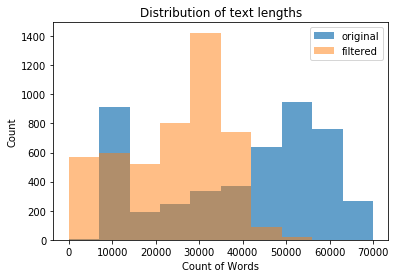

In [103]:
plt.hist(lengths, label='original', range=(0, 70000), alpha=0.7)
plt.hist(f_lengths, label='filtered', range=(0, 70000), alpha=0.5)
plt.legend(loc='best')
plt.title('Distribution of text lengths')
plt.xlabel('Count of Words')
plt.ylabel('Count')
plt.savefig('./plots/leng.png', dpi=600, bbox_inches='tight')
plt.show()

## Entity identification
### Look for (brackets) in text

In [104]:
full_df = papers_auths

In [ ]:
abbr_counter = Counter()  # counts the abbreviations 
pattern = re.compile(r'\([ ]*[A-Z]+[s]?[ ]*\)') # ( followed by zero or more spaces, upper case
                                                # only upper case, can have a trailing s
bad_words = ['of', 'and', 'the', 'for', 'to', 'in', 'as', 'on', 'be', 'a', 'an']
abbr_to_full = {} # abbrs to list of full forms
full_to_abbr = {} # full forms to abbrs

for row in papers_auths.itertuples():
    text = row.Text
    text = re.sub(r'[^A-Za-z\(\) ]+', '', text)  # ignore everything not in [a-zA-Z] and ()
    text = re.sub(r'[ ]*\([ ]*', '(', text)  # take care of the spacing around (
    text = re.sub(r'[ ]+\)', ')', text) # similarly for the )

    for b_w in bad_words: 
        text = text.replace(f' {b_w} ', ' ') # replacing the 'bad' words with space
    
    abbrs = re.findall(pattern, text)  # find the indices of all patterns

    if len(abbrs) > 4:  # this includes the opening and closing ()
        for abbr in abbrs: 
            len_abbr = len(abbr) 
            if abbr.endswith('s)'):
                len_abbr -= 1
            
            for i in [m.start() for m in re.finditer(abbr, text)]:  # indices                
                temp_st = text[: i - 1]
            
                stuff = [thing for thing in temp_st.split(' ') if thing != '']

                first_letters = ''.join(w[0].upper() for w in stuff[-(len_abbr - 2): ])
                if first_letters == abbr[1: len_abbr - 1]:
                    full_form = '_'.join(map(lambda x: x.lower(), stuff[-(len_abbr - 2): ]))
                    full_form = full_form.replace('(', '')
                    if abbr not in abbr_to_full:
                        abbr_to_full[abbr] = Counter()
                        abbr_to_full[abbr][full_form] = 1
                    else:
                        abbr_to_full[abbr][full_form] += 1
                    if full_form not in full_to_abbr:
                        full_to_abbr[full_form] = Counter()
                        full_to_abbr[full_form][abbr] = 1
                    else:
                        full_to_abbr[full_form][abbr] += 1
            abbr_counter[abbr] += 1

In [ ]:
with open('abbr_counter.pkl', 'wb') as f:
    pickle.dump(abbr_counter, f)
    
with open('abbr_to_full.pkl', 'wb') as f:
    pickle.dump(abbr_to_full, f)
    
with open('full_to_abbr.pkl', 'wb') as f:
    pickle.dump(full_to_abbr, f)    

Read from pickles

In [105]:
with open('abbr_counter.pkl', 'rb') as f:
    abbr_counter = pickle.load(f)

with open('full_to_abbr.pkl', 'rb') as f:
    full_to_abbr = pickle.load(f)
    
with open('abbr_to_full.pkl', 'rb') as f:
    abbr_to_full = pickle.load(f)

In [112]:
sorted(abbr_counter.items(), key=lambda x: x[1], reverse=True)[: 5]

[('(IWC)', 1044),
 ('(ICDM)', 662),
 ('(WWW)', 528),
 ('(KDD)', 429),
 ('(SVM)', 332)]

In [108]:
sorted(abbr_to_full.items(), key=lambda x: -max(x[1].values()))[: 5]

[('(ICDM)',
  Counter({'ieee_conf_data_mining': 3,
           'ieee_conference_data_mining': 1,
           'ieeeinternational_conference_data_mining': 2,
           'industrial_conference_data_mining': 9,
           'int_conf_data_mining': 53,
           'international_conference_data_mining': 3922,
           'intl_conf_data_mining': 19,
           'intl_conference_data_mining': 1})),
 ('(NIPS)',
  Counter({'neural_info_processing_systems': 11,
           'neural_information_processing_sys': 1,
           'neural_information_processing_system': 1,
           'neural_information_processing_systems': 617,
           'neural_information_procession_systems': 4})),
 ('(WWW)', Counter({'world_wide_web': 611, 'world_wide_webconference': 16})),
 ('(ICML)',
  Counter({'int_conf_machine_learning': 32,
           'inter_conf_machine_learning': 1,
           'international_conf_machine_learning': 3,
           'international_conference_machine_learning': 550,
           'international_conference_

In [109]:
full_to_abbr['support_vector_machines']

Counter({'(SVM)': 160, '(SVMs)': 130})

In [110]:
for k, counter in sorted(full_to_abbr.items(), key=lambda x: -max(x[1].values()))[:20]:
    print(k, '->', sorted(counter.items(), key=lambda x: x[1], reverse=True))

international_conference_data_mining -> [('(ICDM)', 3922)]
neural_information_processing_systems -> [('(NIPS)', 617)]
world_wide_web -> [('(WWW)', 611)]
international_conference_machine_learning -> [('(ICML)', 550)]
latent_dirichlet_allocation -> [('(LDA)', 380)]
support_vector_machine -> [('(SVM)', 313)]
bucket_parameter_estimation -> [('(BPE)', 280)]
web_search_data_mining -> [('(WSDM)', 262)]
click_through_rate -> [('(CTR)', 235)]
expectation_maximization -> [('(EM)', 233)]
knowledge_base -> [('(KB)', 232)]
singular_value_decomposition -> [('(SVD)', 227)]
stochastic_gradient_descent -> [('(SGD)', 178)]
collaborative_filtering -> [('(CF)', 165)]
support_vector_machines -> [('(SVM)', 160), ('(SVMs)', 130)]
very_large_data_bases -> [('(VLDB)', 156)]
principal_component_analysis -> [('(PCA)', 153)]
latent_semantic_indexing -> [('(LSI)', 150)]
mean_average_precision -> [('(MAP)', 148)]
crowdsourcing_search_data_mining -> [('(CSDM)', 147)]


Abbreviations - done

Top 500 abbreviations as bag of words

In [292]:
top_400 = sorted(full_to_abbr.items(), 
                 key=lambda x: -max(x[1].values()))[: 400]
bag_of_words_abbr = set(map(lambda x: x[0].replace('_', ' '), top_400))
    

In [293]:
list(bag_of_words_abbr)[: 5]

['topic detection tracking',
 'intl conf data mining',
 'supervised random walks',
 'information geometry metric learning',
 'area under curve']

We mine keywords now

In [115]:
papers_auths.Keywords[: 3].values

array([ list(['topic modeling', 'latent dirichlet allocation', 'stochastic optimization']),
       list(['algorithms', 'feature selection', 'maximum likelihood estimate', 'parameter estimation', 'complex data', 'gradient descent']),
       list(['social networks'])], dtype=object)

In [116]:
keyword_counts = Counter()
for keywords in papers_auths.Keywords:
    for keyword in keywords:
        keyword_counts[keyword] += 1
fil_keyword_counts = {k: v for k, v in keyword_counts.items() if v > 100}        

In [117]:
len(keyword_counts)

3853

In [130]:
sorted(fil_keyword_counts.items(), key=lambda x: -x[1])[: 20]

[('data mining', 661),
 ('search engine', 314),
 ('social network', 292),
 ('web pages', 260),
 ('machine learning', 220),
 ('semantic web', 184),
 ('social networks', 180),
 ('social media', 163),
 ('information retrieval', 160),
 ('clustering', 142),
 ('algorithms', 141),
 ('indexation', 136),
 ('classification', 120),
 ('learning artificial intelligence', 119),
 ('web service', 108),
 ('recommender system', 104),
 ('satisfiability', 104)]

In [127]:
bag_of_words = set() # set of features
bag_of_words |= set(fil_keyword_counts.keys())

In [128]:
len(bag_of_words), list(bag_of_words)[: 10]

(17,
 ['web pages',
  'information retrieval',
  'machine learning',
  'data mining',
  'search engine',
  'classification',
  'social media',
  'learning artificial intelligence',
  'satisfiability',
  'recommender system'])

Feature extraction using n-gram 

In [135]:
word2count = Counter()
for f_text in papers_auths.Text:
    words_list = list(map(lambda x: x.lower(), f_text.split()))  # convert words to lowercase
    for word in words_list:
        word = word.strip()
        if word in stopwords or len(word) == 1 or not word.isalpha():
            continue
        word2count[word] += 1

Code adapted from Dr. Jiang's ResponseBot

1. Start with a word, go on to the next one 
2. If next word is a stopword, break, start with the next word
3. Else, add the word to the dictionary indexed at (size - 1) and make the first word equal to the appended word


In [142]:
n_gram = 5 #maximum n-gram considered

bigram2score = [{} for i in range(n_gram)]  # this stores the scores of the n-grams
for word,support in word2count.items():
    bigram2score[0][word] = [support,0]  # the first key is the (length of ngram - 1), 
                                         # second is the word. The value is a list of two nos
                                         # support and the final score (which is 0 initially)

L = 0 # total number of words
    
for words_list in papers_auths.Text:
    words = list(map(lambda x: x.lower(), words_list.split()))
    n = len(words)
    L += n
    for i,i_word in enumerate(words):
        size = 1
        if i_word in  word2count:
            for j in range(min(i+1, n-2), min(n-1, i + n_gram)):
                j_word = words[j]
                if j_word in word2count:
                    bigram = i_word + '_|_' + j_word
                    i_word = bigram
                    if bigram not in bigram2score[size]:
                        bigram2score[size][bigram] = [0, 0]
                    bigram2score[size][bigram][0] += 1
                    size += 1
                else:
                    break

# with open('bigram2score_no_score_5.pkl', 'wb') as f: # pickling it 
#     pickle.dump(bigram2score, f)


In [132]:
with open('bigram2score_no_score_5.pkl', 'rb') as f: # unpickling it 
    bigram2score = pickle.load(f)
L = 36718859

bigram2score[1] has all the bigrams

In [133]:
bigram2score[1]['fp_|_growth']

[275, 0]

In [137]:
sorted(word2count.items(), key=lambda x: -x[1])[: 5]

[('data', 144071),
 ('set', 78899),
 ('web', 72671),
 ('model', 70985),
 ('user', 69569)]

Top 5 bigrams wrt support counts

In [139]:
sorted(bigram2score[1].items(), key=lambda x: -x[1][0])[: 5]

[('data_|_mining', [11846, 0]),
 ('data_|_set', [10108, 0]),
 ('machine_|_learning', [7431, 0]),
 ('data_|_sets', [7321, 0]),
 ('search_|_engine', [6509, 0])]

Scoring the n-grams
1. Treat the first work as P1 and everything else as P2
2. calculate the outlier-ness score for the pair, using the support of each P1 and P2
3. Increase the size of P1 to include first word of P2, decrease the size of P2 to exclude its first word
4. Repeat until size(P2) is 1
5. take the average of all the outlierness score as the score of the n-gram

In [144]:
###
#score n-grams
for i in range(1,len(bigram2score)):
    for key,values in bigram2score[i].items():
        grams = key.split('_|_')
        score = 0
        size = len(grams)
        for j in range(1, size):
            p1 = grams[: j]
            p1_size = j
            p2_size = size-j
            p2 = grams[j:]
            p1 = '_|_'.join(p1)
            p2 = '_|_'.join(p2)
            p1_count = bigram2score[p1_size-1][p1][0]
            p2_count = bigram2score[p2_size-1][p2][0]
            score += (bigram2score[size-1][key][0] - p1_count*p2_count/L)/((bigram2score[size-1][key][0])**0.5)
        score /= size-1
        bigram2score[size-1][key][1] = score

top 5 n-grams sorted by score

In [147]:
for i in range(1,n_gram):
    for key,values in sorted(bigram2score[i].items(),key=lambda x:-x[1][1])[: 5]:
        if len(set(key.split('_|_'))) == len(key.split('_|_')):
            print(key, values)

data_|_mining [11846, 107.8246044649]
data_|_set [10108, 97.4594322261533]
machine_|_learning [7431, 86.06550302987627]
data_|_sets [7321, 84.70192992305198]
search_|_engine [6509, 80.53389020547549]
world_|_wide_|_web [4745, 68.80222797985908]
general_|_terms_|_algorithms [1480, 38.4317052013364]
support_|_vector_|_machines [1177, 34.29685267754257]
neural_|_information_|_processing [941, 30.66980342255905]
information_|_processing_|_systems [920, 30.291729666830328]
neural_|_information_|_processing_|_systems [914, 30.22606885939926]
real_|_world_|_data_|_sets [282, 16.76327914163331]
data_|_mining_|_general_|_terms [239, 15.404060675659535]
mining_|_general_|_terms_|_algorithms [223, 14.901172928886448]
large_|_scale_|_hypertextual_|_web_|_search [144, 11.992961275362614]
scale_|_hypertextual_|_web_|_search_|_engine [143, 11.956052274790785]
data_|_mining_|_general_|_terms_|_algorithms [143, 11.925926363059624]
mining_|_association_|_rules_|_between_|_sets [87, 9.324271275419598]


In [ ]:
# with open('bigram2score_score_10.pkl', 'wb') as f:
#     pickle.dump(bigram2score, f)

range of n-grams scores - only take n-grams with score greater than 5

In [148]:
min(bigram2score[3].items(), key=lambda x: x[1][1]), max(bigram2score[3].items(), key=lambda x: x[1][1])

(('world_|_wide_|_web_|_data', [1, -5.248514512211105]),
 ('neural_|_information_|_processing_|_systems', [914, 30.22606885939926]))

In [152]:
min(filtered_bigram2score_3.items(), key=lambda x: x[1][1]), max(filtered_bigram2score_3.items(), key=lambda x: x[1][1])

(('data_|_cache_|_size', [26, 5.001763141034381]),
 ('world_|_wide_|_web', [4745, 68.80222797985908]))

In [155]:
fil_ngrams = {} #filtered n-grams
for n in range(1, 5):
    top_n = sorted(bigram2score[n].items(), key=lambda x: -x[1][1])[: 3]
    for entity, support, score in top_n:
        print()
    
    fil_ngrams[n] = top_n
#     print(top_n)
#     bag_of_words |= set(map(lambda x: x[0].replace('_|_', ' '), top_n))

[('data_|_mining', [11846, 107.8246044649]), ('data_|_set', [10108, 97.4594322261533]), ('machine_|_learning', [7431, 86.06550302987627]), ('data_|_sets', [7321, 84.70192992305198]), ('search_|_engine', [6509, 80.53389020547549])]
[('world_|_wide_|_web', [4745, 68.80222797985908]), ('general_|_terms_|_algorithms', [1480, 38.4317052013364]), ('support_|_vector_|_machines', [1177, 34.29685267754257]), ('neural_|_information_|_processing', [941, 30.66980342255905]), ('information_|_processing_|_systems', [920, 30.291729666830328])]
[('neural_|_information_|_processing_|_systems', [914, 30.22606885939926]), ('real_|_world_|_data_|_sets', [282, 16.76327914163331]), ('data_|_mining_|_general_|_terms', [239, 15.404060675659535]), ('fl_|_fl_|_fl_|_fl', [228, 15.09872789608923]), ('mining_|_general_|_terms_|_algorithms', [223, 14.901172928886448])]
[('fl_|_fl_|_fl_|_fl_|_fl', [183, 13.527069984208378]), ('large_|_scale_|_hypertextual_|_web_|_search', [144, 11.992961275362614]), ('scale_|_hypert

In [154]:
len(bag_of_words)

407

In [ ]:
# with open('bigram_pickle.pkl', 'wb') as f:
#     pickle.dump(bigram2score, f)

we have n-grams and keywords in bag of words

## TASK 2 - done

## Entity typing - sliding window

In [ ]:
s_method = set('method algorithm model approach framework process scheme implementation procedure strategy architecture'.split())
s_problem = set('problem technique process system application task evaluation tool paradigm benchmark software'.split())
s_dataset = set('data dataset database'.split())
s_metric = set('value score measure metric function parameter'.split())

In [ ]:
len(full_to_abbr)

In [ ]:
entity_count_list = []

for window_len in range(1, 6):
    entity_counts = {}
    for row in full_df.itertuples():
        text = row.Text    
        text = re.sub(r'[^A-Za-z\(\) ]+', '', text)
        text = re.sub(r'[ ]*\([ ]*', '(', text)
        text = re.sub(r'[ ]+\)', ')', text)
        
        for word in full_to_abbr.keys():
#             word = word.replace('(', '')
            if sum(full_to_abbr[word].values()) < 10:
                continue
            if word not in entity_counts:
                entity_counts[word] = {}
            word = word.replace('_', ' ')
            num_words = len(word.split())
            try:
                indices = [m.start() for m in re.finditer(word, text)]
            except:
                continue
            for i in indices:                
                before_st = text[(i - 1) - 100: i - 1]
                after_st = text[i: i + 100] # load up the next 100 characters
                stuff_before = [thing for thing in before_st.split(' ') if thing != ''][-window_len: ]
                stuff_after = [thing for thing in after_st.split(' ') if thing != ''][num_words: (num_words) + window_len]
#                 print(stuff_before, word, stuff_after)
                
                stuff_before = set(stuff_before)
                stuff_after = set(stuff_after)
                stuff = stuff_before | stuff_after
                kword = word.replace(' ', '_')                 
                if len(stuff & s_method) > 0:
                    if 'MT' not in entity_counts[kword]:
                        entity_counts[kword]['MT'] = len(stuff & s_method)
                    else:
                        entity_counts[kword]['MT'] += len(stuff & s_method)
                if len(stuff & s_problem) > 0:
                    if 'P' not in entity_counts[kword]:
                        entity_counts[kword]['P'] = len(stuff & s_problem)
                    else:
                        entity_counts[kword]['P'] += len(stuff & s_problem)
                if len(stuff & s_dataset) > 0:
                    if 'D' not in entity_counts[kword]:
                        entity_counts[kword]['D'] = len(stuff & s_dataset)
                    else:
                        entity_counts[kword]['D'] += len(stuff & s_dataset)
                if len(stuff & s_metric) > 0:
                    if 'MR' not in entity_counts[kword]:
                        entity_counts[kword]['MR'] = len(stuff & s_metric)
                    else:
                        entity_counts[kword]['MR'] += len(stuff & s_metric)
    entity_count_list.append(entity_counts)
filtered_entity_counts = {k: v for k, v in entity_counts.items()
                         if len(v) > 0}

In [ ]:
len(entity_count_list)

In [ ]:
import pickle 

In [ ]:
with open('entity_list_pickle.pkl', 'wb') as f:
    pickle.dump(entity_count_list, f)

In [171]:
with open('entity_list_pickle.pkl', 'rb') as f:
    entity_count_list = pickle.load(f)

Take a vote across the window sizes to decide the type

In [172]:
entity_count_list[1]['support_vector_machines']

{'D': 9, 'MR': 3, 'MT': 13, 'P': 7}

In [173]:
cum_counts = {}  # cumulative counts
for entity in entity_count_list[0].keys():
    cum_counts[entity] = {k: entity_count_list[0][entity].get(k, 0) + 
                          entity_count_list[1][entity].get(k, 0) +
                          entity_count_list[2][entity].get(k, 0) +
                          entity_count_list[3][entity].get(k, 0) + 
                          entity_count_list[4][entity].get(k, 0)
                          for k in ['P', 'MT', 'MR', 'D'] }

filtered_counts = {k: v for k, v in cum_counts.items() if max(v.values()) > 0}     

In [174]:
sorted(filtered_counts.items(), key=lambda x: -max(x[1].values()))[: 20]

[('update', {'D': 1820, 'MR': 1362, 'MT': 4133, 'P': 1235}),
 ('data_mining', {'D': 1541, 'MR': 134, 'MT': 2366, 'P': 3395}),
 ('machine_learning', {'D': 1558, 'MR': 97, 'MT': 2407, 'P': 1187}),
 ('random_walk', {'D': 178, 'MR': 264, 'MT': 1796, 'P': 444}),
 ('collaborative_filtering', {'D': 164, 'MR': 79, 'MT': 1728, 'P': 520}),
 ('logistic_regression', {'D': 137, 'MR': 111, 'MT': 1632, 'P': 244}),
 ('decision_tree', {'D': 433, 'MR': 105, 'MT': 1505, 'P': 338}),
 ('itemset', {'D': 1057, 'MR': 412, 'MT': 1412, 'P': 555}),
 ('matrix_factorization', {'D': 133, 'MR': 59, 'MT': 1310, 'P': 286}),
 ('language_model', {'D': 75, 'MR': 109, 'MT': 1172, 'P': 171}),
 ('topic_model', {'D': 219, 'MR': 123, 'MT': 1169, 'P': 345}),
 ('information_retrieval', {'D': 433, 'MR': 172, 'MT': 1022, 'P': 1157}),
 ('nearest_neighbor', {'D': 216, 'MR': 215, 'MT': 882, 'P': 242}),
 ('linear_regression', {'D': 76, 'MR': 109, 'MT': 875, 'P': 220}),
 ('semi_supervised_learning', {'D': 111, 'MR': 26, 'MT': 784, 'P'

## Classify each entity

In [175]:
clas = {}
for entity, dic in filtered_counts.items():
    max_count = dic['P']
    max_thing = 'P'
    for thing in ['MT', 'MR', 'D']:
        if dic[thing] > max_count:
            max_count = dic[thing]
            max_thing = thing
    clas[entity] = max_thing

In [176]:
series = pd.Series(list(clas.values()))

In [177]:
len(clas.keys())

231

In [178]:
series.value_counts()

MT    139
P      43
D      26
MR     23
dtype: int64

In [295]:
for item, dic in sorted(filtered_counts.items(), key=lambda x: -sum(x[1].values()))[: 20]:
    if item == 'update' or item == 'graph_a':
        continue
    print(item, dic['P'], dic['MT'], dic['MR'], dic['D'])

data_mining 3395 2366 134 1541
machine_learning 1187 2407 97 1558
itemset 555 1412 412 1057
information_retrieval 1157 1022 172 433
random_walk 444 1796 264 178
collaborative_filtering 520 1728 79 164
decision_tree 338 1505 105 433
logistic_regression 244 1632 111 137
topic_model 345 1169 123 219
matrix_factorization 286 1310 59 133
cross_validation 225 737 281 454
nearest_neighbor 242 882 215 216
language_model 171 1172 109 75
linear_regression 220 875 109 76
outlier_detection 308 658 58 204
semi_supervised_learning 290 784 26 111
knowledge_base 308 395 42 195
vertices 170 484 124 147


In [ ]:
for i in range(n_gram):
    for key,values in sorted(bigram2score[i].items(),key=lambda x:-x[1][1])[: 10]:
        if len(set(key.split('_|_'))) == len(key.split('_|_')):
            print(key, values)
#         print (f'"{key}", {values}')

In [ ]:
# with open('bigram2score_score_10.pkl', 'wb') as f:
#     pickle.dump(bigram2score, f)

In [ ]:
min(bigram2score[3].items(), key=lambda x: x[1][1]), max(bigram2score[3].items(), key=lambda x: x[1][1])

In [ ]:
filtered_bigram2score_4 = dict(filter(lambda x: x[1][1] > 5, bigram2score[3].items()))

In [ ]:
filtered_bigram2score_3 = dict(filter(lambda x: x[1][1] > 5, bigram2score[2].items()))

In [ ]:
len(bigram2score[3]), len(filtered_bigram2score_3)

In [ ]:
min(filtered_bigram2score_3.items(), key=lambda x: x[1][1]), max(filtered_bigram2score_3.items(), key=lambda x: x[1][1])

In [165]:
fil_ngrams = {}
for n in range(1, 5):
    top_n = sorted(bigram2score[n].items(), key=lambda x: -x[1][1])[: 100]
    for word, support_score in top_n:
        word = word.replace('_|_',  ' ')
        support, score = support_score
        bag_of_words.add(word)


In [294]:
len(bag_of_words)

407

In [ ]:
with open('bigram_pickle.pkl', 'wb') as f:
    pickle.dump(bigram2score, f)

we have n-grams and keywords in bag of words

## TASK 4 

In [296]:
transactions = authors.AIDs.tolist()

In [297]:
patterns = apriori(transactions, supp=-5, zmin=2)
print ('-------- Apriori --------')
print ('Number of patterns:',len(patterns))
for (pattern,support) in sorted(patterns,key=lambda x:-x[1])[: 10]:
    for aid in pattern:
        print (author[author.AID==aid].AUT.values[0], end=', ')
    print(support)

-------- Apriori --------
Number of patterns: 124
jun yan, zheng chen, 11
alexander j smola, amr ahmed, 10
guirong xue, yong yu, 10
ning liu, zheng chen, 9
irwin king, michael r lyu, 9
chun chen, jiajun bu, 9
jing gao, jiawei han, 9
yizhou sun, jiawei han, 8
juanzi li, jie tang, 8
ning liu, jun yan, zheng chen, 8


In [298]:
rules = apriori(transactions,target='r', supp=-10, conf=50, report='sc')

print ('-------- Top 20 One-to-Many Association Rules (conf) --------')
for (lhs,rhs,support,confidence) in sorted(rules,key=lambda x: -x[-1])[: 20]:
    print (author[author.AID==lhs].AUT.values[0],'--> ', end=' ')
#     print(rhs)
    print(', '.join(
                map(lambda x: 
                    author[author.AID==x].AUT.values[0], 
                    rhs)),
           round(support, 3), round(confidence, 3))
print ('Number of rules:',len(rules))


-------- Top 20 One-to-Many Association Rules (conf) --------
zheng chen -->  jun yan 0.002 1.0
christos faloutsos -->  hanghang tong 0.002 0.8
yong yu -->  guirong xue 0.002 0.769
ning liu -->  jun yan, zheng chen 0.002 0.727
ning liu -->  jun yan 0.002 0.727
amr ahmed -->  alexander j smola 0.002 0.714
erik mannens -->  rik van de walle 0.001 0.7
alexander j smola -->  amr ahmed 0.002 0.667
evgeniy gabrilovich -->  bo pang 0.001 0.636
vanja josifovski -->  andrei broder 0.002 0.615
ruben verborgh -->  rik van de walle 0.001 0.6
zheng chen -->  huajun zeng 0.001 0.6
michael r lyu -->  irwin king 0.002 0.6
jiawei han -->  jing gao 0.002 0.6
jon kleinberg -->  lars backstrom 0.001 0.583
vanja josifovski -->  evgeniy gabrilovich 0.002 0.571
jiawei han -->  xifeng yan 0.002 0.571
zheng chen -->  gang wang 0.001 0.545
irwin king -->  michael r lyu 0.002 0.529
rui cai -->  lei zhang 0.001 0.5
Number of rules: 21


In [299]:
rules = apriori(transactions,target='r', supp=-10, conf=50, report='l')
# output
print('Lift')
print ('-------- Top 20 One-to-Many Association Rules (lift) --------')
for (lhs,rhs,lift) in sorted(rules,key=lambda x: -x[-1])[: 20]:
    print (author[author.AID==lhs].AUT.values[0],'--> ', end=' ')
#     print(rhs)
    print(', '.join(
                map(lambda x: 
                    author[author.AID==x].AUT.values[0], 
                    rhs)),
           round(lift, 3))
print ('Number of rules:',len(rules))

Lift
-------- Top 20 One-to-Many Association Rules (lift) --------
ruben verborgh -->  rik van de walle 510.1
erik mannens -->  rik van de walle 510.1
rui cai -->  lei zhang 425.083
ning liu -->  jun yan, zheng chen 412.202
ning liu -->  jun yan 412.202
amr ahmed -->  alexander j smola 242.905
alexander j smola -->  amr ahmed 242.905
evgeniy gabrilovich -->  bo pang 231.864
bo pang -->  evgeniy gabrilovich 231.864
yong yu -->  guirong xue 186.85
zheng chen -->  jun yan 182.179
michael r lyu -->  irwin king 180.035
irwin king -->  michael r lyu 180.035
jon kleinberg -->  lars backstrom 135.254
vanja josifovski -->  andrei broder 125.563
vanja josifovski -->  evgeniy gabrilovich 116.594
zheng chen -->  huajun zeng 109.307
zheng chen -->  gang wang 99.37
christos faloutsos -->  hanghang tong 76.996
jiawei han -->  jing gao 37.785
Number of rules: 21


# Task 5
problem => method

author => problem

dataset => method

problem => dataset

Get rid of 'updates' and 'graph_a' since it adds no value

In [203]:
problems = set(k.replace('_', ' ') for k, v in clas.items() if v == 'P')
methods = set(k.replace('_', ' ') for k, v in clas.items() if v == 'MT')
datasets = set(k.replace('_', ' ') for k, v in clas.items() if v == 'D')

methods.discard('update')
methods.discard('graph a')

In [204]:
list(problems)[: 5]

['quadratic programming',
 'contrastive opinion summarization',
 'topic detection tracking',
 'information retrieval',
 'root mean square error']

In [182]:
list(methods)[: 5]

['gaussian mixture model',
 'topic model',
 'itemset',
 'locality sensitive hashing',
 'class conditional decorrelation']

In [183]:
for word1 in methods | problems:
    for word2 in methods | problems:
        if word1.endswith('s') and word1[: -1] == word2:
            print(f"'{word1}'", end=', ')

'hidden markov models', 'knowledge bases', 'conditional random fields', 'maximal frequent cohesive sets', 'support vector machines', 'frequent cohesive sets', 

In [206]:
trans_prob_method = []
plurals = set(['conditional random fields', 'frequent cohesive sets', 
               'knowledge bases', 'hidden markov models', 
               'maximal frequent cohesive sets', 'support vector machines'])
for f_text in full_df.fil_text:
    trans  = []
    for problem in problems:
        if problem in f_text:
            if problem in plurals:
                problem = problem[: -1]
            trans.append(problem)
    for method in methods:    
        if method in f_text:
            if method in plurals:
                method = method[: -1]
            trans.append(method)
    if len(trans) > 0:
        trans_prob_method.append(trans)

In [199]:
patterns = apriori(trans_prob_method, supp=-100, zmin=2)
print ('-------- Apriori --------')
print ('Number of patterns:',len(patterns))
for (pattern,support) in sorted(patterns,key=lambda x:-x[1])[: 10]:
    print (pattern,support)


-------- Apriori --------
Number of patterns: 336
('machine learning', 'data mining') 1563
('world wide web', 'data mining') 898
('information retrieval', 'world wide web') 848
('information retrieval', 'machine learning') 831
('information retrieval', 'data mining') 826
('world wide web', 'machine learning') 790
('cross validation', 'machine learning') 606
('cross validation', 'data mining') 574
('information retrieval', 'machine learning', 'data mining') 569
('support vector machine', 'machine learning') 564


Problems2methods stores the problems as key and the different methods as a set of values

In [301]:
rules = apriori(trans_prob_method, target='r', supp=-10)
problems2methods = {}
for rule in rules:
    left, right, supp = rule
    if left in problems:
        if len(set(right))  == len(set(right) & methods):
            if left not in problems2methods:
                problems2methods[left] = set(right)
            else:
                problems2methods[left] |= set(right)
#             print(f'{left} -> {right} ({supp})')

methods2problems stores the methods as key and the different problems as a set of values

In [193]:
methods2problems = {}
for rule in rules:
    left, right, supp = rule
    if left in methods:
#         if left != 'machine learning' and \
        if len(set(right))  == len(set(right) & problems):
            if left not in methods2problems:
                methods2problems[left] = set(right)
            else:
                methods2problems[left] |= set(right)
#             print(f'{left} -> {right} ({supp})')

In [302]:
for method, problem in methods2problems.items():
    print(method, list(problem)[: 5])
    print()

world wide web ['community question answering', 'instant messaging', 'relation extraction', 'information retrieval', 'information extraction']

machine learning ['quadratic programming', 'information retrieval', 'inter arrival times', 'root mean square error', 'integer linear program']

cost per click ['post click conversion', 'data mining']

logistic regression ['semi definite programming', 'linear programming', 'post click conversion', 'data mining', 'linear program']

knowledge base ['integer linear program', 'question answering', 'linear program']

cross validation ['quadratic programming', 'community question answering', 'information retrieval', 'question answering', 'data mining']

support vector machine ['semi definite programming', 'linear programming', 'data mining', 'linear program']

natural language processing ['relation extraction', 'information extraction', 'information retrieval', 'linear programming', 'question answering']

linear regression ['question answering', 'root

In [303]:
for problem, methods in problems2methods.items():
    print(problem, list(methods)[: 5])
    print()

information retrieval ['document frequency', 'world wide web', 'machine learning', 'nearest neighbor', 'cross validation']

data mining ['world wide web', 'nearest neighbor', 'machine learning', 'cross validation', 'vector space model']



method => data

In [216]:
trans_data_meth = []

for f_text in full_df.fil_text:
    trans  = []
    for method in methods:
        if method in f_text:
            trans.append(method)
    for data in datasets:    
        if data in f_text:
            trans.append(data)
    if len(trans) > 0:
        trans_data_meth.append(trans)

In [217]:
patterns = apriori(trans_data_meth, supp=-100, zmin=2)
print ('-------- Apriori --------')
print ('Number of patterns:',len(patterns))
for (pattern,support) in sorted(patterns,key=lambda x:-x[1])[: 10]:
    print (pattern,support)


-------- Apriori --------
Number of patterns: 47
('information system', 'world wide web') 857
('world wide web', 'machine learning') 790
('information system', 'machine learning') 652
('cross validation', 'machine learning') 606
('nearest neighbor', 'machine learning') 360
('natural language processing', 'machine learning') 338
('information system', 'world wide web', 'machine learning') 336
('online social networks', 'online social network') 299
('natural language processing', 'world wide web') 298
('class labels', 'machine learning') 289


In [224]:
rules = apriori(trans_data_meth, target='r', supp=-10)
methods2data = {}
for rule in rules:
    left, right, supp = rule
    if left in methods:
        if len(set(right))  == len(set(right) & datasets):
            if left not in methods2data:
                methods2data[left] = set(right)
            else:
                methods2data[left] |= set(right)
#             print(f'{left} -> {right} ({supp})')

In [225]:
methods2data

{'machine learning': {'class labels',
  'information system',
  'online social network',
  'online social networks',
  'training ratio'}}

## Task 6

In [226]:
papers_auths.head()

PID                                         title_case  year conf  \
0  7A81E8D5  Stochastic Divergence Minimization for Online ...  2015  kdd   
1  7D60588D  Grafting-light: fast, incremental feature sele...  2010  kdd   
2  76065173                            Debiasing social wisdom  2013  kdd   
3  7D72D04B                 The contextual focused topic model  2012  kdd   
4  768B16AB  Interpreting Advertiser Intent in Sponsored Se...  2015  kdd   

        CID folder        PDFid  \
0  436976F3  kdd15  kdd15-p1035   
1  436976F3  kdd10    kdd10-d81   
2  436976F3  kdd13    kdd13-d48   
3  436976F3  kdd12   kdd12-d202   
4  436976F3  kdd15  kdd15-p2177   

                                               title  \
0  stochastic divergence minimization for online ...   
1  grafting light fast incremental feature select...   
2                            debiasing social wisdom   
3                 the contextual focused topic model   
4  interpreting advertiser intent in sponsored se...   

                                            Keywords  \
0  [topic modeling, latent dirichlet allocation, ...   
1  [algorithms, feature selection, maximum likeli...   
2                                  [social networks]   
3       [topic modeling, clustering, random effects]   
4                               [online advertising]   

                                                AFFs  \
0         [university of tokyo, university of tokyo]   
1  [carnegie mellon university, carnegie mellon u...   
2       [microsoft, microsoft, microsoft, microsoft]   
3  [duke university, duke university, duke univer...   
4  [university of california san diego, microsoft...   

                                                AIDs  \
0                               [800DD778, 817628DB]   
1                     [84A938BA, 7FDD7A85, 14EED946]   
2           [7E17537C, 78986B23, 7B6F49C4, 84FF4740]   
3                     [84B613E3, 81583A41, 272FB205]   
4  [7A3643B2, 84E4D65D, 85305AA4, 80B1DC4A, 7FF0D...   

                                                AUTs  \
0                     [issei sato, hiroshi nakagawa]   
1                     [jun zhu, ni lao, eric p xing]   
2  [abhimanyu das, sreenivas gollapudi, rina pani...   
3           [xu chen, mingyuan zhou, lawrence carin]   
4  [bhanu c vattikonda, santhosh kodipaka, hongya...   

                                                FIDs  \
0                               [04756336, 04756336]   
1                     [0477FFD3, 0477FFD3, 0477FFD3]   
2           [4CE6FC2D, 4CE6FC2D, 4CE6FC2D, 4CE6FC2D]   
3                     [0A2FAFA5, 0A2FAFA5, 0A2FAFA5]   
4  [0229448F, 4CE6FC2D, 4CE6FC2D, 4CE6FC2D, 4CE6F...   

                                                Text  \
0  Stochastic Divergence Minimization for Online ...   
1  Grafting Light : Fast , Incremental Feature Se...   
2  Debiasing Social Wisdom\nAbhimanyu Das Microso...   
3  The Contextual Focused Topic Model\nXu Chen\nD...   
4  Interpreting Advertiser Intent in Sponsored Se...   

                                            fil_text  
0  stochastic divergence minimization online coll...  
1  grafting light fast incremental feature select...  
2  debiasing social wisdom abhimanyu das microsof...  
3  contextual focused topic model xu chen departm...  
4  interpreting advertiser intent sponsored searc...

Making the feature vectors using the bag of words

In [237]:
list(bag_of_words)[: 5]

['power law degree distribution',
 'mining time changing data streams',
 'general terms',
 'modern information retrieval',
 'mining general terms']

In [238]:
# vocab
feature_vecs = {}
for row in papers_auths.itertuples():
    feature_vec = []
    for feature in bag_of_words:
        feature = feature.strip()
        if len(feature) == 1:
            print(feature)
        count = row.Text.count(feature)
        feature_vec.append(count)
    feature_vecs[row.PID] = feature_vec

In [239]:
vec_df = pd.DataFrame(list(feature_vecs.values()), 
                       columns=bag_of_words, 
                       index=feature_vecs.keys())
vec_df.shape

(4759, 407)

In [240]:
vec_df = vec_df.reset_index()
vec_df.rename(columns={'index': 'PID'}, inplace=True)

In [242]:
df = pd.merge(papers_auths, vec_df, on='PID')
df.head()

PID                                         title_case  year conf  \
0  7A81E8D5  Stochastic Divergence Minimization for Online ...  2015  kdd   
1  7D60588D  Grafting-light: fast, incremental feature sele...  2010  kdd   
2  76065173                            Debiasing social wisdom  2013  kdd   
3  7D72D04B                 The contextual focused topic model  2012  kdd   
4  768B16AB  Interpreting Advertiser Intent in Sponsored Se...  2015  kdd   

        CID folder        PDFid  \
0  436976F3  kdd15  kdd15-p1035   
1  436976F3  kdd10    kdd10-d81   
2  436976F3  kdd13    kdd13-d48   
3  436976F3  kdd12   kdd12-d202   
4  436976F3  kdd15  kdd15-p2177   

                                               title  \
0  stochastic divergence minimization for online ...   
1  grafting light fast incremental feature select...   
2                            debiasing social wisdom   
3                 the contextual focused topic model   
4  interpreting advertiser intent in sponsored se...   

                                            Keywords  \
0  [topic modeling, latent dirichlet allocation, ...   
1  [algorithms, feature selection, maximum likeli...   
2                                  [social networks]   
3       [topic modeling, clustering, random effects]   
4                               [online advertising]   

                                                AFFs     ...      \
0         [university of tokyo, university of tokyo]     ...       
1  [carnegie mellon university, carnegie mellon u...     ...       
2       [microsoft, microsoft, microsoft, microsoft]     ...       
3  [duke university, duke university, duke univer...     ...       
4  [university of california san diego, microsoft...     ...       

  high dimensional feature space data web semantic web  \
0                              0                     0   
1                              1                     0   
2                              0                     0   
3                              0                     0   
4                              0                     0   

  social networking sites defense advanced research projects agency  \
0                       0                                         0   
1                       0                                         0   
2                       0                                         0   
3                       0                                         0   
4                       0                                         0   

  data set contains  real data sets  labeled data  \
0                 0               0             0   
1                 0               3             0   
2                 0               0             0   
3                 0               0             0   
4                 0               0             0   

   crowd oriented service data  topically categorized web query log  \
0                            0                                    0   
1                            0                                    0   
2                            0                                    0   
3                            0                                    0   
4                            0                                    0   

   acm sigkdd  
0           0  
1           0  
2           0  
3           0  
4           0  

[5 rows x 422 columns]

In [243]:
df['in_kdd'] = df.conf.apply(lambda x: x == 'kdd')

In [244]:
df[df.conf=='kdd'].iloc[: 5, -2: ]

acm sigkdd  in_kdd
0           0    True
1           0    True
2           0    True
3           0    True
4           0    True

In [267]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

In [246]:
clf = RandomForestClassifier()

columns 15 and on contain the features

In [257]:
df.iloc[1, 15: 20]

power law degree distribution        0
mining time changing data streams    0
general terms                        0
modern information retrieval         0
mining general terms                 0
Name: 1, dtype: object

In [258]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 15: -1], 
                 df.iloc[:, -1].tolist(),
                random_state=42)

In [259]:
X_train.shape, X_test.shape

((3569, 407), (1190, 407))

In [260]:
len(y_train), len(y_test)

(3569, 1190)

In [261]:
clf = RandomForestClassifier(n_jobs=2, random_state=0)

In [262]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [263]:
y_pred = clf.predict(X_test)

In [264]:
from sklearn.metrics import accuracy_score

In [265]:
accuracy_score(y_pred, y_test)

0.7579831932773109

In [268]:
classifiers = [
    KNeighborsClassifier(3),
#     SVC(kernel="linear", C=0.025),
#     SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, n_jobs=2),
    MLPClassifier(),
    AdaBoostClassifier(),
    GaussianNB()]

In [273]:
for name, clf in zip(['KNN', 'Decision Tree', 'Random Forest', 'MLP', 
                     'AdaBoost', 'Naive Bayes'], classifiers):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(name, ' & ', round(accuracy_score(y_pred, y_test), 3), r' \\ \hline' )


KNN  &  0.735  \\ \hline
Decision Tree  &  0.756  \\ \hline
Random Forest  &  0.722  \\ \hline
MLP  &  0.776  \\ \hline
AdaBoost  &  0.774  \\ \hline
Naive Bayes  &  0.745  \\ \hline


In [ ]:
list(full_to_abbr.keys())[: 5]

In [235]:
filtered_entities = sorted(full_to_abbr.items(),
                          key=lambda x: 
                           -max(x[1].values()))

In [236]:
filtered_entities[: 5]

[('international_conference_data_mining', Counter({'(ICDM)': 3922})),
 ('neural_information_processing_systems', Counter({'(NIPS)': 617})),
 ('world_wide_web', Counter({'(WWW)': 611})),
 ('international_conference_machine_learning', Counter({'(ICML)': 550})),
 ('latent_dirichlet_allocation', Counter({'(LDA)': 380}))]

In [ ]:
vocab = list(map(lambda x: x[0].replace('_', ' '),
               filtered_entities))
vocab = set(word.strip() for word in vocab if len(word) > 1)

In [ ]:
bag_of_words |= vocab

In [227]:
len(bag_of_words)

407

In [ ]:
len(bag_of_words)

In [ ]:
list(vocab)[: 10], len(vocab)

In [ ]:
vec_lengths = {k: len(v) for k, v in feature_counters.items()}

In [ ]:
len(bag_of_words)

In [ ]:
len(['7080AFC1'])

(4759, 407)

In [ ]:
pred_df.pickle('pred_all.pickle')

In [ ]:
pred_df.head()

In [ ]:
pred_df.to_pickle('pred_all.pkl')

In [ ]:
pred_df = pd.read_pickle

In [ ]:
pred_df.shape

In [231]:
pred_df.head()

PID  power law degree distribution  mining time changing data streams  \
0  7A81E8D5                              0                                  0   
1  7D60588D                              0                                  0   
2  76065173                              0                                  0   
3  7D72D04B                              0                                  0   
4  768B16AB                              0                                  0   

   general terms  modern information retrieval  mining general terms  \
0              0                             0                     0   
1              0                             0                     0   
2              0                             0                     0   
3              0                             0                     0   
4              0                             0                     0   

   defense advanced research projects  different types  \
0                                   0                0   
1                                   0                0   
2                                   0                1   
3                                   0                0   
4                                   0                2   

   database applications data mining  search result page     ...      \
0                                  0                   0     ...       
1                                  0                   0     ...       
2                                  0                   0     ...       
3                                  0                   0     ...       
4                                  0                   0     ...       

   high dimensional feature space  data web semantic web  \
0                               0                      0   
1                               1                      0   
2                               0                      0   
3                               0                      0   
4                               0                      0   

   social networking sites  defense advanced research projects agency  \
0                        0                                          0   
1                        0                                          0   
2                        0                                          0   
3                        0                                          0   
4                        0                                          0   

   data set contains  real data sets  labeled data  \
0                  0               0             0   
1                  0               3             0   
2                  0               0             0   
3                  0               0             0   
4                  0               0             0   

   crowd oriented service data  topically categorized web query log  \
0                            0                                    0   
1                            0                                    0   
2                            0                                    0   
3                            0                                    0   
4                            0                                    0   

   acm sigkdd  
0           0  
1           0  
2           0  
3           0  
4           0  

[5 rows x 408 columns]

www     2461
kdd     1437
icdm     550
wsdm     311
Name: conf, dtype: int64

In [233]:
df['in_kdd'] = df.conf.apply(lambda x: x == 'kdd')

acm sigkdd  in_kdd
0           0    True
1           0    True
2           0    True
3           0    True
4           0    True

In [ ]:
clf.fit(df.iloc[: 15, :-1], 
        df.iloc[: 15, -1].tolist())

In [ ]:
clf.predict(small_df.iloc[15:, :-1])

In [ ]:
df.iloc[: 10, 13:]

In [ ]:
small_df.head()

In [ ]:
X_train.shape, X_test.shape

In [ ]:
len(y_train), len(y_test)

In [ ]:
clf = RandomForestClassifier(n_jobs=2, random_state=0)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_pred, y_test)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [ ]:
classifiers = [
    KNeighborsClassifier(3),
#     SVC(kernel="linear", C=0.025),
#     SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB()]

In [ ]:
for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('--------')
    print(clf, accuracy_score(y_pred, y_test))
    print('--------')

In [ ]:
df.head()

# TASK 7

In [274]:
from sklearn import cluster

In [276]:
kmeans = cluster.KMeans(n_clusters=4, random_state=0)

In [277]:
kmeans.fit(df.iloc[:, 15: -1])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [278]:
kmeans.labels_[: 5]

array([3, 2, 2, 3, 3], dtype=int32)

In [279]:
df.conf.value_counts()

www     2461
kdd     1437
icdm     550
wsdm     311
Name: conf, dtype: int64

In [280]:
df['clu_id'] = kmeans.labels_

In [281]:
df[df['clu_id'] == 0].conf.value_counts()

kdd     149
icdm     56
www      54
wsdm     16
Name: conf, dtype: int64

In [282]:
df[df['clu_id'] == 1].conf.value_counts()

kdd     94
icdm    36
www     20
wsdm     9
Name: conf, dtype: int64

In [283]:
df[df['clu_id'] == 2].conf.value_counts()

kdd     287
www     100
icdm     95
wsdm     39
Name: conf, dtype: int64

In [284]:
df[df['clu_id'] == 3].conf.value_counts()

www     2287
kdd      907
icdm     363
wsdm     247
Name: conf, dtype: int64

In [285]:
kmeans.inertia_

4263593.1748896232

In [305]:
from sklearn.neighbors import kneighbors_graph

In [307]:
connectivity = kneighbors_graph(
        df.iloc[:, 16: -1], n_neighbors=3, include_self=False)
    # make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

In [308]:
ward = cluster.AgglomerativeClustering(
        n_clusters=4, linkage='ward',
        connectivity=connectivity)

In [310]:
ward.fit(df.iloc[:, 16: -1])

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=<4759x4759 sparse matrix of type '<class 'numpy.float64'>'
	with 25786 stored elements in Compressed Sparse Row format>,
            linkage='ward', memory=None, n_clusters=4,
            pooling_func=<function mean at 0x7fe6c8045730>)

In [311]:
ward.labels_[: 5]

array([2, 0, 2, 2, 2])

In [312]:
df['clu_h'] = ward.labels_

In [313]:
df[df['clu_h'] == 0].conf.value_counts()

kdd     338
icdm    133
www      97
wsdm     32
Name: conf, dtype: int64

In [314]:
df[df['clu_h'] == 1].conf.value_counts()

kdd     81
icdm    23
www     13
wsdm     7
Name: conf, dtype: int64

In [315]:
df[df['clu_h'] == 2].conf.value_counts()

www     2301
kdd      969
icdm     389
wsdm     258
Name: conf, dtype: int64

In [316]:
df[df['clu_h'] == 3].conf.value_counts()

www     50
kdd     49
wsdm    14
icdm     5
Name: conf, dtype: int64

In [ ]:
df.conf.value_counts()